In [1]:
import os
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
import math

from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler


In [2]:
df = pd.read_csv(r"C:\Users\mohni\OneDrive - SSN Trust\Vscode\Datasets\Air_quality.csv", parse_dates=['Date'], index_col='Date')
df

,value
Date,
07-11-2017,99.805833
08-11-2017,110.979565
09-11-2017,114.915833
10-11-2017,119.404091
11-11-2017,109.267273
...,...
31-05-2022,41.465417
01-06-2022,41.645833
02-06-2022,42.255417


In [3]:
df.index = pd.to_datetime(df.index, format='%d-%m-%Y')


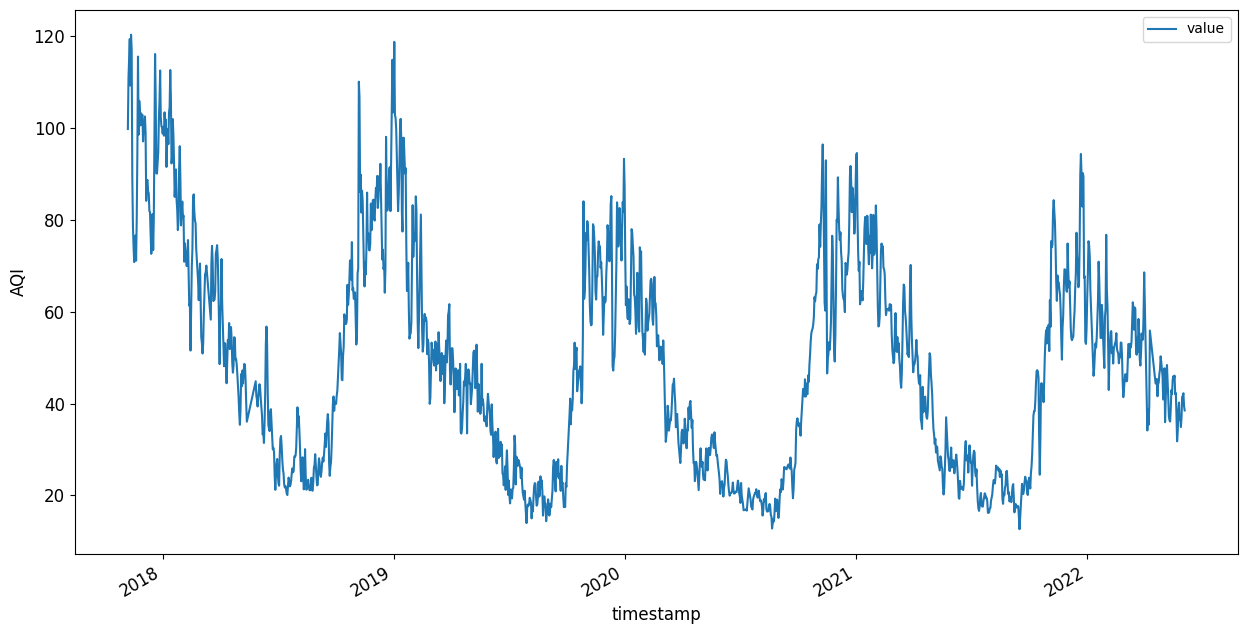

In [4]:
df.plot(y='value', subplots=True, figsize=(15, 8), fontsize=12)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('AQI', fontsize=12)
plt.show()

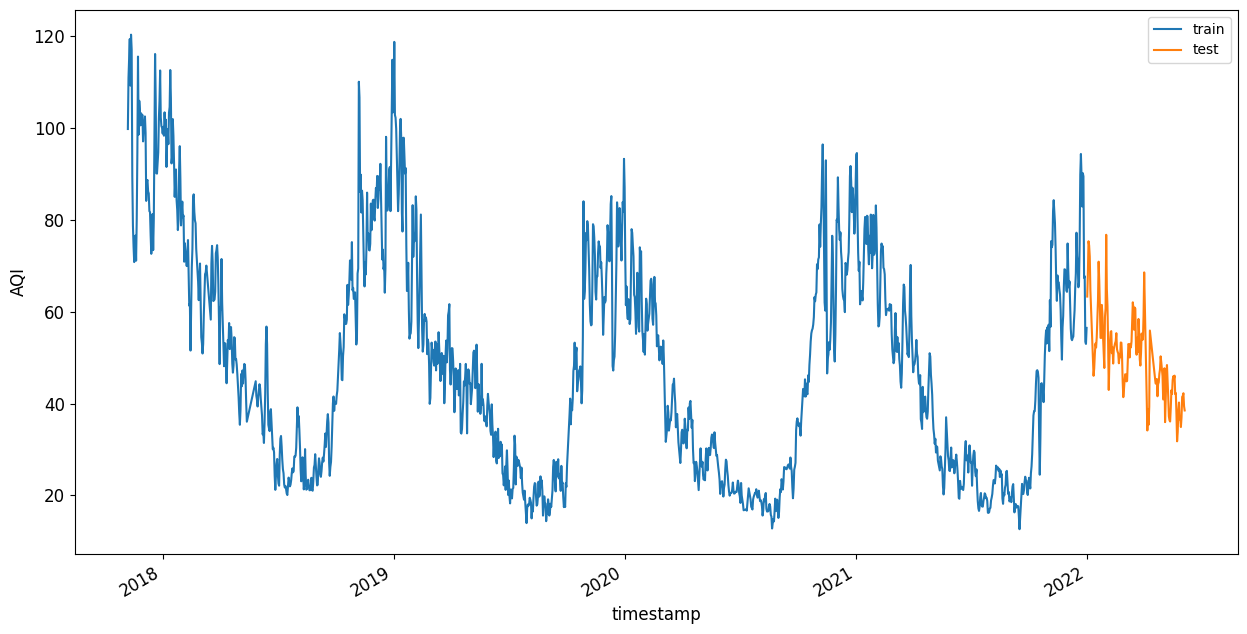

In [5]:
train_start_dt = '2017-11-07'
test_start_dt = '2022-01-01'

# Convert index to datetime format
df.index = pd.to_datetime(df.index, format='%d-%m-%Y')

df[(df.index < test_start_dt) & (df.index >= train_start_dt)][['value']].rename(columns={'value':'train'}) \
    .join(df[test_start_dt:][['value']].rename(columns={'value':'test'}), how='outer') \
    .plot(y=['train', 'test'], figsize=(15, 8), fontsize=12)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('AQI', fontsize=12)
plt.show()


In [6]:
train = df.copy()[(df.index >= train_start_dt) & (df.index < test_start_dt)][['value']]
test = df.copy()[df.index >= test_start_dt][['value']]

print('Training data shape: ', train.shape)
print('Test data shape: ', test.shape)

Training data shape:  (1477, 1)
Test data shape:  (139, 1)


In [7]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
train['value'] = scaler.fit_transform(train)

In [8]:
test['value'] = scaler.transform(test)

In [9]:
train_data = train.values
test_data = test.values

In [10]:
timesteps=5

In [11]:
train_data_timesteps=np.array([[j for j in train_data[i:i+timesteps]] for i in range(0,len(train_data)-timesteps+1)])[:,:,0]
train_data_timesteps.shape

(1473, 5)

In [12]:
test_data_timesteps=np.array([[j for j in test_data[i:i+timesteps]] for i in range(0,len(test_data)-timesteps+1)])[:,:,0]
test_data_timesteps.shape

(135, 5)

In [13]:
x_train, y_train = train_data_timesteps[:,:timesteps-1],train_data_timesteps[:,[timesteps-1]]
x_test, y_test = test_data_timesteps[:,:timesteps-1],test_data_timesteps[:,[timesteps-1]]

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(1473, 4) (1473, 1)
(135, 4) (135, 1)


In [14]:
model = SVR(kernel='rbf',gamma=0.5, C=10, epsilon = 0.05)


In [15]:
model.fit(x_train, y_train[:,0])


SVR(C=10, epsilon=0.05, gamma=0.5)

In [16]:
y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_test).reshape(-1,1)

print(y_train_pred.shape, y_test_pred.shape)

(1473,) (135, 1)


In [17]:
# Scaling the predictions
y_train_pred = scaler.inverse_transform(y_train_pred.reshape(-1, 1))
y_test_pred = scaler.inverse_transform(y_test_pred.reshape(-1, 1))

print(len(y_train_pred), len(y_test_pred))


1473 135


In [18]:
# Scaling the original values
y_train = scaler.inverse_transform(y_train)
y_test = scaler.inverse_transform(y_test)

print(len(y_train), len(y_test))

1473 135


In [19]:
train_timestamps = df[(df.index < test_start_dt) & (df.index >= train_start_dt)].index[timesteps-1:]
test_timestamps = df[test_start_dt:].index[timesteps-1:]

print(len(train_timestamps), len(test_timestamps))

1473 135


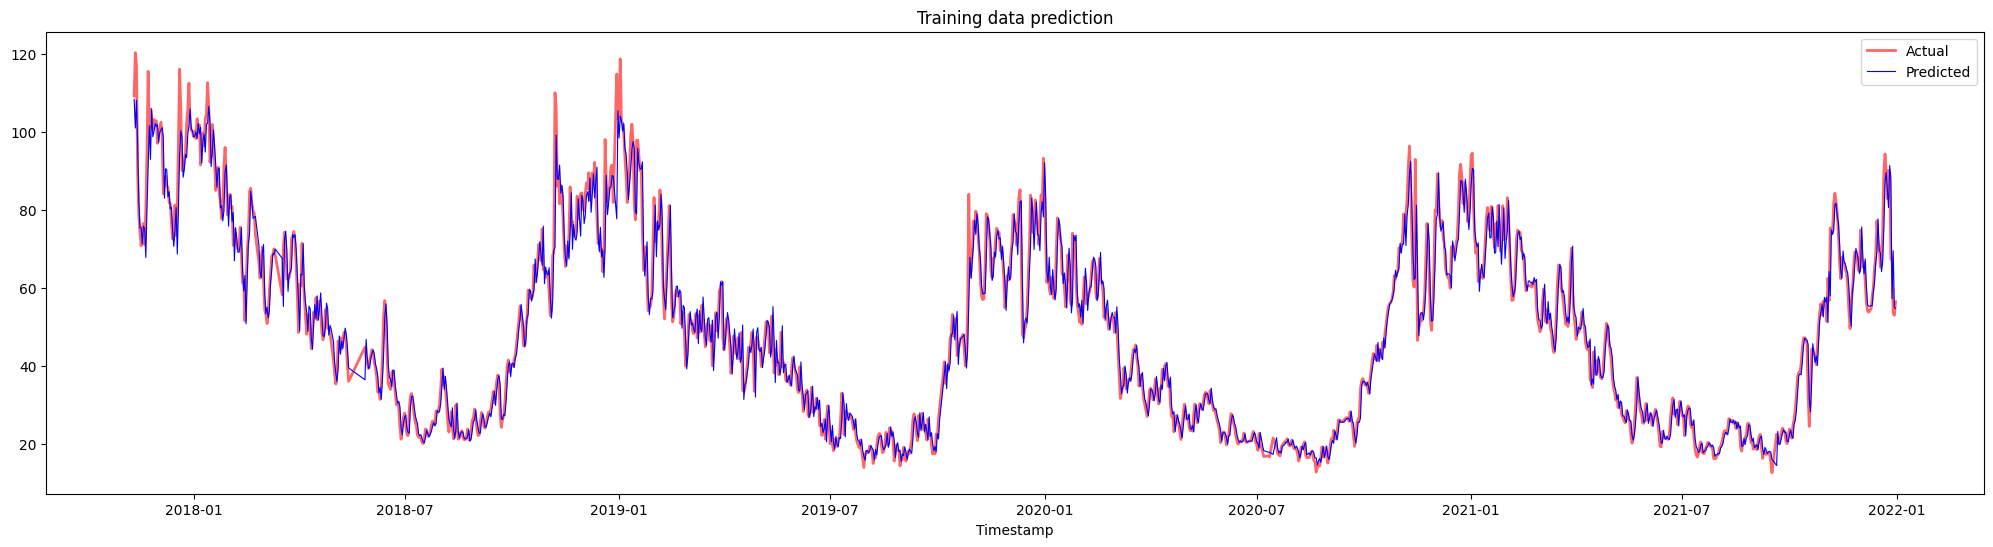

In [20]:
plt.figure(figsize=(25,6))
plt.plot(train_timestamps, y_train, color = 'red', linewidth=2.0, alpha = 0.6)
plt.plot(train_timestamps, y_train_pred, color = 'blue', linewidth=0.8)
plt.legend(['Actual','Predicted'])
plt.xlabel('Timestamp')
plt.title("Training data prediction")
plt.show()

In [21]:
from sklearn.metrics import mean_absolute_percentage_error as mape

print('MAPE for training data: ', mape(y_train_pred, y_train)*100, '%')

MAPE for training data:  7.145031781331566 %


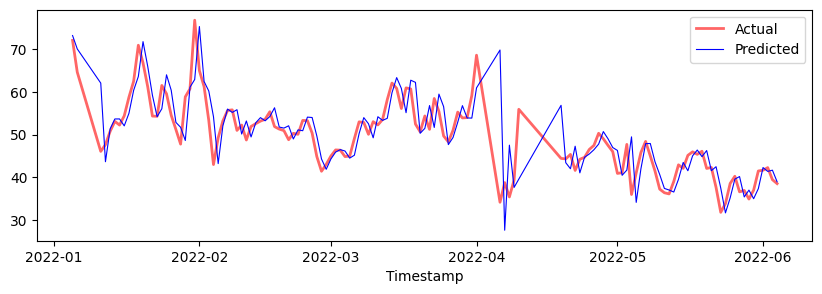

In [22]:
plt.figure(figsize=(10,3))
plt.plot(test_timestamps, y_test, color = 'red', linewidth=2.0, alpha = 0.6)
plt.plot(test_timestamps, y_test_pred, color = 'blue', linewidth=0.8)
plt.legend(['Actual','Predicted'])
plt.xlabel('Timestamp')
plt.show()

In [23]:
print('MAPE for testing data: ', mape(y_test_pred, y_test)*100, '%')

MAPE for testing data:  7.296639547965329 %


In [24]:
from sklearn.metrics import r2_score

# Calculate R2 score
r2 = r2_score(y_test, y_test_pred)
print('R2 score for testing data:', r2)


R2 score for testing data: 0.5552566892278723


In [25]:
import numpy as np

pred_val = []
input_array = np.array([[-0.11363332, -0.09865072, -0.16820764, -0.19086075]])
for i in range(90):
    ans = model.predict(input_array[:, -4:]).reshape(-1, 1)
    pred_val.append(ans)
    input_array = np.hstack([input_array, ans])

pred_val = np.array(pred_val).squeeze()


In [26]:
pred_val = scaler.inverse_transform(pred_val.reshape(-1, 1))

In [27]:
date_range = pd.date_range(start='2022-06-04', periods=90)
prediction_df = pd.DataFrame(index=date_range)
prediction_df['value'] = pred_val
prediction_df



,value
2022-06-04,38.422897
2022-06-05,38.781148
2022-06-06,38.931635
2022-06-07,38.934617
2022-06-08,38.867379
...,...
2022-08-28,37.215388
2022-08-29,37.194003
2022-08-30,37.172619
2022-08-31,37.151237


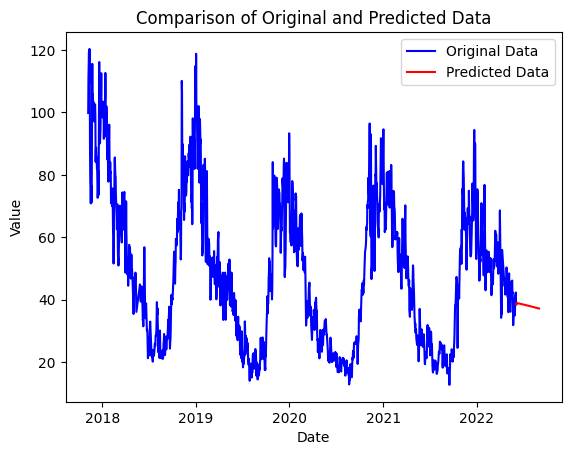

In [28]:
import matplotlib.pyplot as plt

# Plot the original data
plt.plot(df.index, df['value'], label='Original Data', color='blue')
# Plot the predicted data
plt.plot(prediction_df.index, prediction_df['value'], label='Predicted Data', color='red')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Comparison of Original and Predicted Data')

# Add legend
plt.legend()

# Show the plot
plt.show()
